<h1>Практическая работа №6 и Лабораторная работа №4<h1>
<h2>Выполнила: Бардасова Ирина<h2>
<h2>Группа: ББМО-02-22<h2/>

 **Шаг 1**
Выполним импорт необходимых библиотек.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets

**Шаг 2**
Загрузим набор данных (MNIST), разобьем данные на подвыборки.


In [2]:
transform = transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)
print("Training data:",len(train_loader),"Validation data:",len(val_loader),"Test data:",len(test_loader))

100%|██████████| 9912422/9912422 [00:00<00:00, 140793343.78it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 40868992.52it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 42148994.99it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 20707096.49it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training data: 50000 Validation data: 10000 Test data: 10000


**Шаг 3**
Настроим использование графического ускорителя.

In [3]:
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

**Шаг 4. Создание атак на модель НС.**
Создадим класс НС на основе фреймворка torch.

In [4]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

**Шаг 5. Создание атак на модель НС.**
Проверим работоспособность созданного класса НС.

In [5]:
model = Net().to(device)

**Шаг 6. Создание атак на модель НС.**
Создадим оптимизатор, функцию потерь и трейнер сети.

In [6]:
optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

**Шаг 7. Создание атак на модель НС.**
Определим функцию обучения сети.


In [7]:
def fit(model,device,train_loader,val_loader,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label = data[0].to(device),data[1].to(device)
        output = model(input)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

**Шаг 8. Создание атак на модель НС.**
Обучим модель.

In [8]:
loss, val_loss = fit(model, device, train_loader, val_loader, 10)

Fitting the model...


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 1 Loss: 0.29064843464819934 Val_Loss: 0.13973914129167625
Epoch: 2 Loss: 0.11209722856724741 Val_Loss: 0.09410980466786437
Epoch: 3 Loss: 0.08527212373731685 Val_Loss: 0.09013760282852333
Epoch: 4 Loss: 0.07664654940550142 Val_Loss: 0.083568693905282
Epoch: 5 Loss: 0.06749064147849225 Val_Loss: 0.08116593277261915
Epoch: 6 Loss: 0.06208608291131742 Val_Loss: 0.09247260077951423
Epoch: 7 Loss: 0.06100456084646738 Val_Loss: 0.08571256819688092
Epoch: 8 Loss: 0.05803848488737129 Val_Loss: 0.07620353192351904
Epoch: 9 Loss: 0.05555220137219747 Val_Loss: 0.07989234270428483
Epoch: 10 Loss: 0.054739571796726935 Val_Loss: 0.08621458863847627


**Шаг 9. Создание атак на модель НС.**
Построим графики потерь при обучении и валидации в зависимости от эпохи.


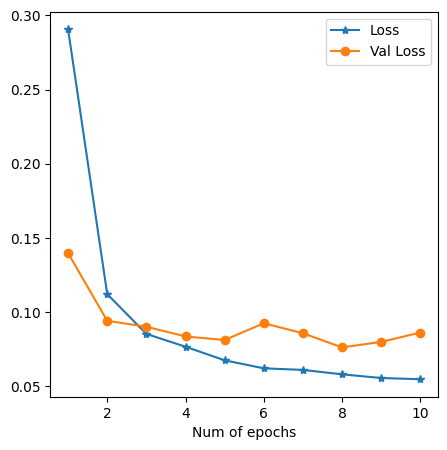

In [9]:
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,11), loss, "*-",label="Loss")
plt.plot(np.arange(1,11), val_loss,"o-",label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()

**Шаг 10. Создание атак на модель НС.**
Создадим функции атак FGSM, I-FGSM, MI-FGSM.

In [10]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

In [11]:
def ifgsm_attack(input,epsilon,data_grad):
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

In [12]:
def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

**Шаг 11. Создание атак на модель НС.**
Создадим функцию проверки.

In [13]:
def test(model,device,test_loader,epsilon,attack):
  correct = 0
  adv_examples = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1]
    if init_pred.item() != target.item():
      continue
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    if attack == "fgsm":
      perturbed_data = fgsm_attack(data,epsilon,data_grad)
    elif attack == "ifgsm":
      perturbed_data = ifgsm_attack(data,epsilon,data_grad)
    elif attack == "mifgsm":
      perturbed_data = mifgsm_attack(data,epsilon,data_grad)
    output = model(perturbed_data)
    final_pred = output.max(1, keepdim=True)[1]
    if final_pred.item() == target.item():
      correct += 1
    if (epsilon == 0) and (len(adv_examples) < 5):
      adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
      adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    else:
      if len(adv_examples) < 5:
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
  return final_acc, adv_examples

**Шаг 12. Создание атак на модель НС.**
Построим графики успешности атак(Accuracy/эпсилон) и примеры выполненных атак в зависимости от степени возмущения epsilon:

Epsilon: 0	Test Accuracy = 9681 / 10000 = 0.9681
Epsilon: 0.007	Test Accuracy = 9658 / 10000 = 0.9658
Epsilon: 0.01	Test Accuracy = 9619 / 10000 = 0.9619
Epsilon: 0.02	Test Accuracy = 9569 / 10000 = 0.9569
Epsilon: 0.03	Test Accuracy = 9517 / 10000 = 0.9517
Epsilon: 0.05	Test Accuracy = 9304 / 10000 = 0.9304
Epsilon: 0.1	Test Accuracy = 8572 / 10000 = 0.8572
Epsilon: 0.2	Test Accuracy = 6245 / 10000 = 0.6245
Epsilon: 0.3	Test Accuracy = 4053 / 10000 = 0.4053


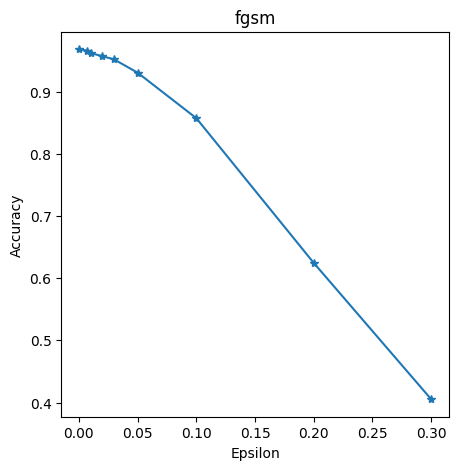

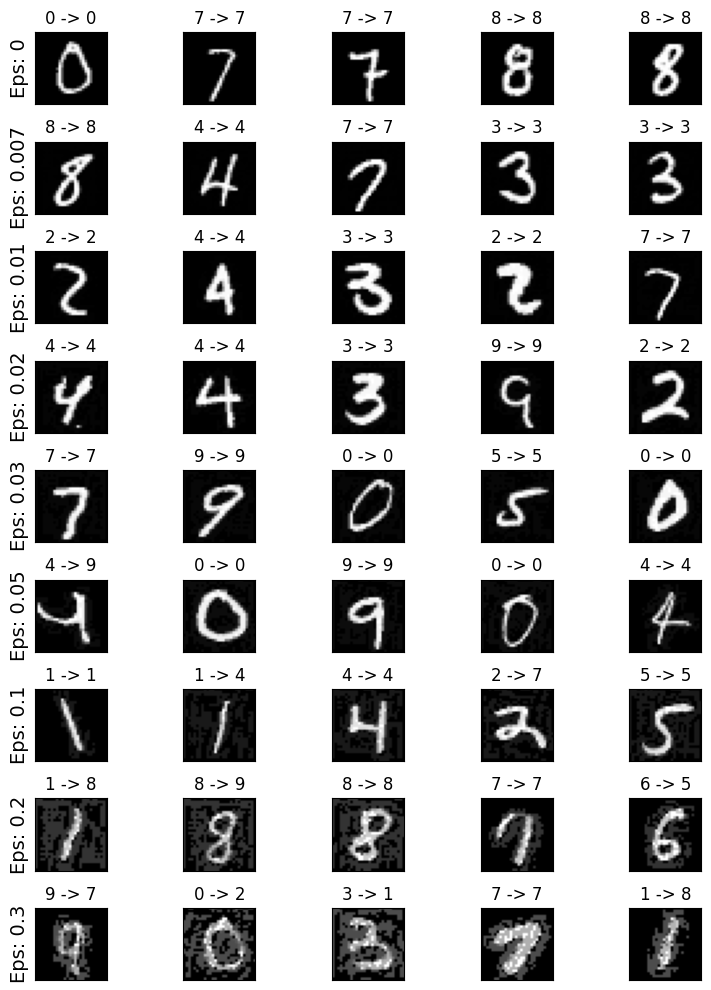

Epsilon: 0	Test Accuracy = 9702 / 10000 = 0.9702
Epsilon: 0.007	Test Accuracy = 9636 / 10000 = 0.9636
Epsilon: 0.01	Test Accuracy = 9644 / 10000 = 0.9644
Epsilon: 0.02	Test Accuracy = 9585 / 10000 = 0.9585
Epsilon: 0.03	Test Accuracy = 9549 / 10000 = 0.9549
Epsilon: 0.05	Test Accuracy = 9393 / 10000 = 0.9393
Epsilon: 0.1	Test Accuracy = 8754 / 10000 = 0.8754
Epsilon: 0.2	Test Accuracy = 6701 / 10000 = 0.6701
Epsilon: 0.3	Test Accuracy = 4703 / 10000 = 0.4703


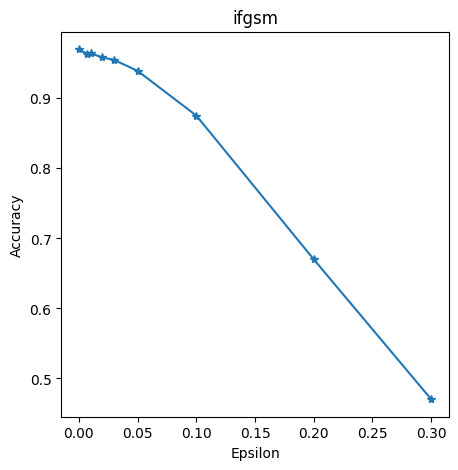

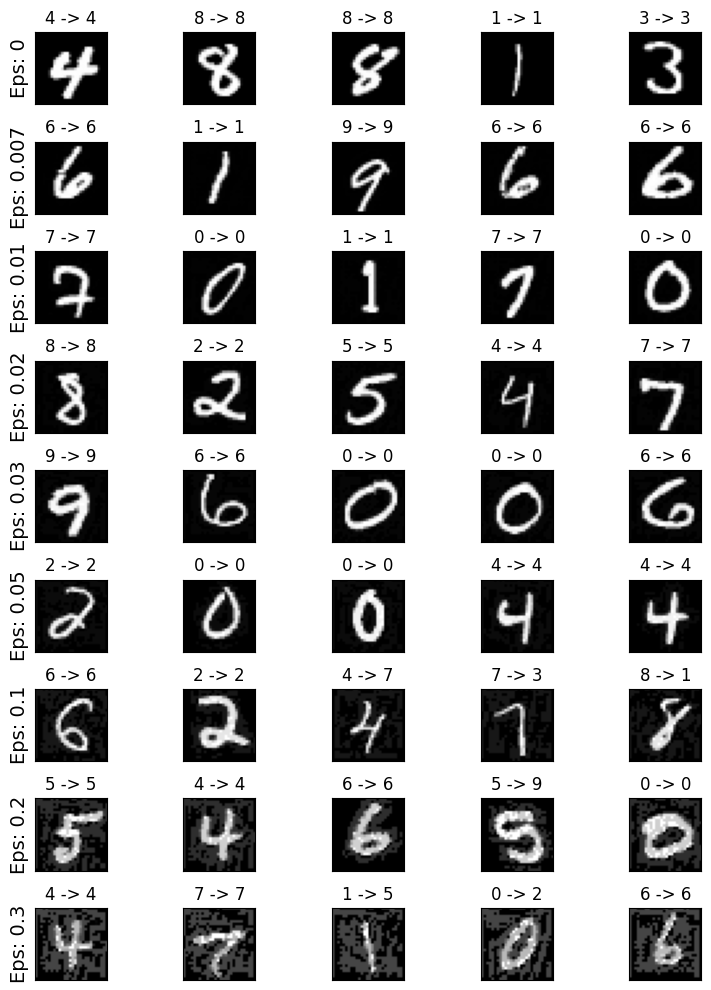

Epsilon: 0	Test Accuracy = 9678 / 10000 = 0.9678
Epsilon: 0.007	Test Accuracy = 9672 / 10000 = 0.9672
Epsilon: 0.01	Test Accuracy = 9645 / 10000 = 0.9645
Epsilon: 0.02	Test Accuracy = 9570 / 10000 = 0.957
Epsilon: 0.03	Test Accuracy = 9547 / 10000 = 0.9547
Epsilon: 0.05	Test Accuracy = 9375 / 10000 = 0.9375
Epsilon: 0.1	Test Accuracy = 8771 / 10000 = 0.8771
Epsilon: 0.2	Test Accuracy = 6724 / 10000 = 0.6724
Epsilon: 0.3	Test Accuracy = 4575 / 10000 = 0.4575


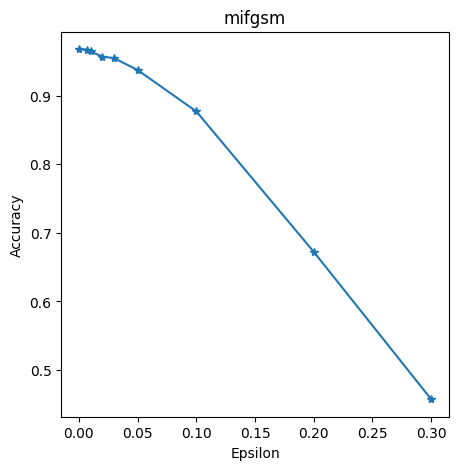

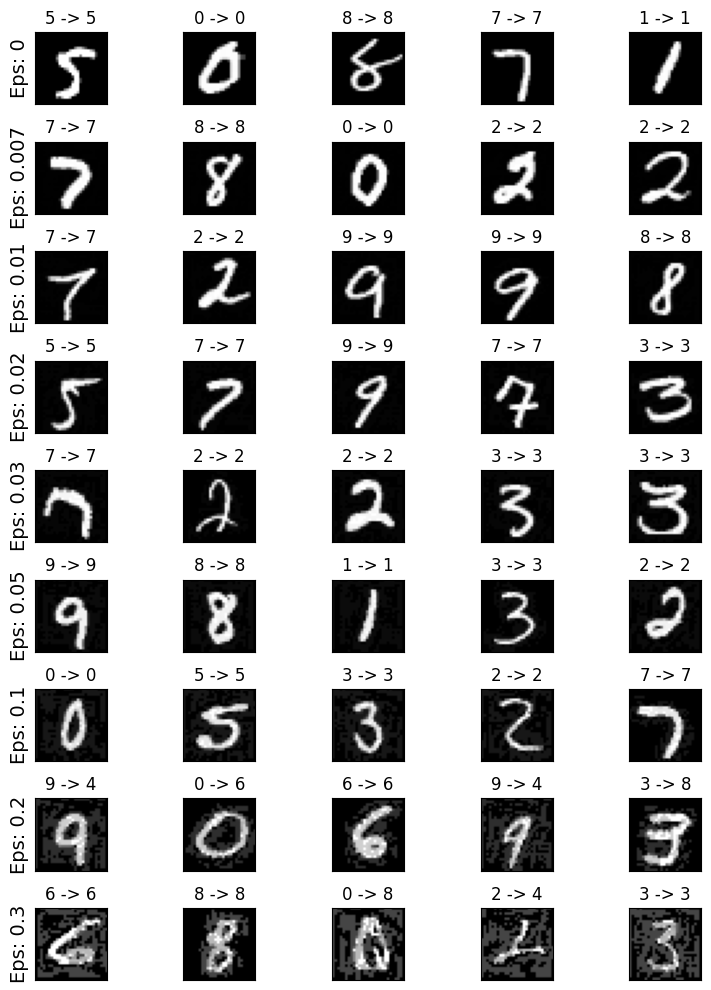

In [14]:
epsilons = [0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
for attack in ("fgsm","ifgsm","mifgsm"):
  accuracies = []
  examples = []
  for eps in epsilons:
    acc, ex = test(model, device,test_loader,eps,attack)
    accuracies.append(acc)
    examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()
  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
    for j in range(len(examples[i])):
      cnt += 1
      plt.subplot(len(epsilons),len(examples[0]),cnt)
      plt.xticks([], [])
      plt.yticks([], [])
      if j == 0:
        plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
      orig,adv,ex = examples[i][j]
      plt.title("{} -> {}".format(orig, adv))
      plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()

**Шаг 13. Защита от атак.**
Создадим 2 класса НС.

In [15]:
class NetF(nn.Module):
  def __init__(self):
    super(NetF, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

In [16]:
class NetF1(nn.Module):
  def __init__(self):
    super(NetF1, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(4608, 64)
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

**Шаг 14. Защита от атак.**
Переопределим функцию обучения и тестирования.

In [17]:
def fit(model,device,optimizer,scheduler,criterion,train_loader,val_loader,Temp,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label = data[0].to(device),data[1].to(device)
        output = model(input)
        output = F.log_softmax(output/Temp,dim=1)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
      else:
        val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

  def test(model,device,test_loader,epsilon,Temp,attack):
    correct=0
    adv_examples = []
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      data.requires_grad = True
      output = model(data)
      output = F.log_softmax(output/Temp,dim=1)
      init_pred = output.max(1, keepdim=True)[1]
      if init_pred.item() != target.item():
        continue
      loss = F.nll_loss(output, target)
      model.zero_grad()
      loss.backward()
      data_grad = data.grad.data
      if attack == "fgsm":
        perturbed_data = fgsm_attack(data,epsilon,data_grad)
      elif attack == "ifgsm":
        perturbed_data = ifgsm_attack(data,epsilon,data_grad)
      elif attack == "mifgsm":
        perturbed_data = mifgsm_attack(data,epsilon,data_grad)
      output = model(perturbed_data)
      final_pred = output.max(1, keepdim=True)[1]
      if final_pred.item() == target.item():
        correct += 1
        if (epsilon == 0) and (len(adv_examples) < 5):
          adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
          adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
          if len(adv_examples) < 5:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
  return final_acc,adv_examples

**Шаг 15. Защита от атак.**
Создадим функцию защиты методом дистилляции.

In [18]:
def defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons):
  modelF = NetF().to(device)
  optimizerF = optim.Adam(modelF.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF = optim.lr_scheduler.ReduceLROnPlateau(optimizerF, mode='min', factor=0.1, patience=3)
  modelF1 = NetF1().to(device)
  optimizerF1 = optim.Adam(modelF1.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF1 = optim.lr_scheduler.ReduceLROnPlateau(optimizerF1, mode='min', factor=0.1, patience=3)
  criterion = nn.NLLLoss()
  lossF,val_lossF=fit(modelF,device,optimizerF,schedulerF,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF,"o-",label="Val Loss")
  plt.title("Network F")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()
  #converting target labels to soft labels
  for data in train_loader:
    input, label = data[0].to(device),data[1].to(device)
    softlabel = F.log_softmax(modelF(input),dim=1)
    data[1] = softlabel
  lossF1,val_lossF1=fit(modelF1,device,optimizerF1,schedulerF1,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF1, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF1,"o-",label="Val Loss")
  plt.title("Network F'")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()
  model = NetF1().to(device)
  model.load_state_dict(modelF1.state_dict())
  for attack in ("fgsm","ifgsm","mifgsm"):
    accuracies = []
    examples = []
    for eps in epsilons:
      acc, ex = test(model,device,test_loader,eps,"fgsm")
      accuracies.append(acc)
      examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()
  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
    for j in range(len(examples[i])):
      cnt += 1
      plt.subplot(len(epsilons),len(examples[0]),cnt)
      plt.xticks([], [])
      plt.yticks([], [])
      if j == 0:
        plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
      orig,adv,ex = examples[i][j]
      plt.title("{} -> {}".format(orig, adv))
      plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()

**Шаг 16. Защита от атак.**
Получим результаты оценки защищенных сетей.

Fitting the model...
Epoch: 1 Loss: 0.5875381317337817 Val_Loss: 0.0002477751061320305
Epoch: 2 Loss: 0.37223328317865906 Val_Loss: 5.8449041792118806e-05
Epoch: 3 Loss: 0.300203464906997 Val_Loss: 1.1476876195047225e-06
Epoch: 4 Loss: 0.22447578425227732 Val_Loss: 1.024925165111199e-05
Epoch: 5 Loss: 0.1692605609525646 Val_Loss: 1.2469353526830674e-05
Epoch: 6 Loss: 0.13844957534614116 Val_Loss: 1.5843172644963488e-06
Epoch: 7 Loss: 0.12097579994431013 Val_Loss: 2.2935150191187858e-07
Epoch: 8 Loss: 0.10792648130793007 Val_Loss: 2.1327660974475295e-05
Epoch: 9 Loss: 0.09584144328942137 Val_Loss: 1.7687051848042756e-06
Epoch: 10 Loss: 0.09228720086034559 Val_Loss: 6.794159198761917e-08


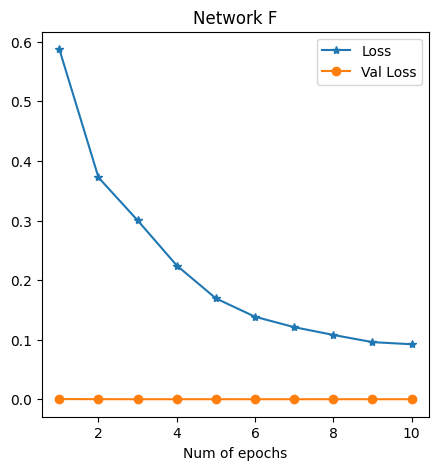

Fitting the model...
Epoch: 1 Loss: 0.677646332978676 Val_Loss: 1.142687419487629e-05
Epoch: 2 Loss: 0.44778661603998104 Val_Loss: 9.403289790498092e-07
Epoch: 3 Loss: 0.38619531052488193 Val_Loss: 0.00031147556453943253
Epoch: 4 Loss: 0.32751098905518494 Val_Loss: 1.0528198938118294e-06
Epoch: 5 Loss: 0.28392189496603476 Val_Loss: 3.608909228205448e-06
Epoch: 6 Loss: 0.2561870969625666 Val_Loss: 6.666882634149261e-05
Epoch: 7 Loss: 0.23164340963596394 Val_Loss: 6.86303600662086e-06
Epoch: 8 Loss: 0.2254040606729585 Val_Loss: 1.1486735893413424e-07
Epoch: 9 Loss: 0.22232407375608804 Val_Loss: 1.8782613551593385e-07
Epoch: 10 Loss: 0.21788871602455848 Val_Loss: 2.5395520031224804e-06


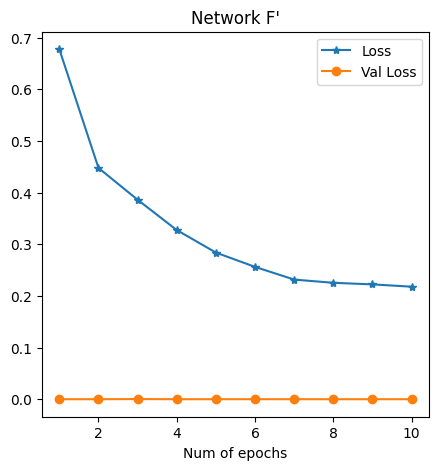

Epsilon: 0	Test Accuracy = 9021 / 10000 = 0.9021
Epsilon: 0.007	Test Accuracy = 9050 / 10000 = 0.905
Epsilon: 0.01	Test Accuracy = 9026 / 10000 = 0.9026
Epsilon: 0.02	Test Accuracy = 8919 / 10000 = 0.8919
Epsilon: 0.03	Test Accuracy = 8821 / 10000 = 0.8821
Epsilon: 0.05	Test Accuracy = 8640 / 10000 = 0.864
Epsilon: 0.1	Test Accuracy = 7763 / 10000 = 0.7763
Epsilon: 0.2	Test Accuracy = 4493 / 10000 = 0.4493
Epsilon: 0.3	Test Accuracy = 1339 / 10000 = 0.1339
Epsilon: 0	Test Accuracy = 9043 / 10000 = 0.9043
Epsilon: 0.007	Test Accuracy = 9022 / 10000 = 0.9022
Epsilon: 0.01	Test Accuracy = 9028 / 10000 = 0.9028
Epsilon: 0.02	Test Accuracy = 8896 / 10000 = 0.8896
Epsilon: 0.03	Test Accuracy = 8839 / 10000 = 0.8839
Epsilon: 0.05	Test Accuracy = 8654 / 10000 = 0.8654
Epsilon: 0.1	Test Accuracy = 7774 / 10000 = 0.7774
Epsilon: 0.2	Test Accuracy = 4543 / 10000 = 0.4543
Epsilon: 0.3	Test Accuracy = 1365 / 10000 = 0.1365
Epsilon: 0	Test Accuracy = 9018 / 10000 = 0.9018
Epsilon: 0.007	Test Accurac

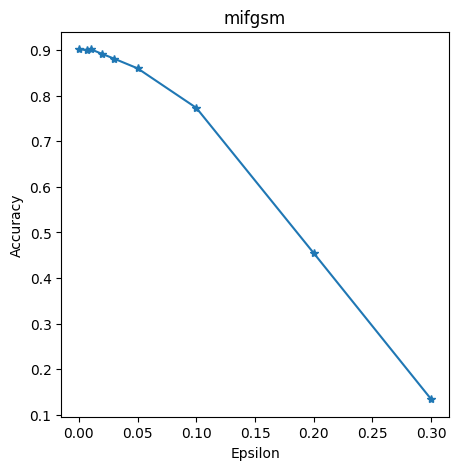

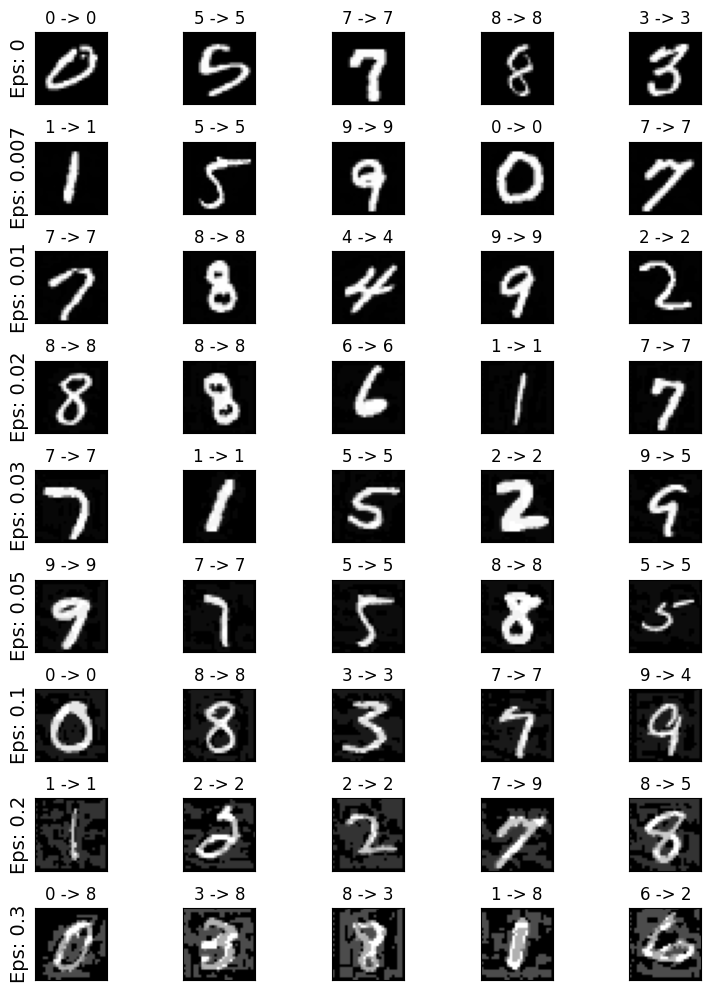

In [19]:
Temp=100
epochs=10
epsilons=[0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons)